In [1]:
!git clone https://github.com/pitthexai/MICCAI2023.git

Cloning into 'MICCAI2023'...
fatal: could not read Username for 'https://github.com': No such device or address


In [4]:
import fnmatch
import glob
import os
from natsort import natsorted
from PIL import Image
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# cd gdrive/MyDrive/pfx01
import os
os.chdir('/content/gdrive/MyDrive/Moradi_Project/knee_mri_localization')

In [5]:
dirpath = "/content/gdrive/MyDrive/Moradi_Project/knee_mri_localization/9010060_10279506_L_NotProgressed"
num_layers = len(fnmatch.filter(os.listdir(dirpath), '*.jpg'))
print(num_layers)

11


In [6]:
import fnmatch
import glob
import os
from natsort import natsorted
from PIL import Image
import numpy as np

# Empty list to store numpy arrays
image_list = []
y = []

# lets us know number of images in that file
# dirpath = "/Users/huntersylvester/Desktop/UMMC/Research/Moradi/sample_knee_mri_localization/9009067_10287112_R_Progressed"
# num_layers = len(fnmatch.filter(os.listdir(dirpath), '*.jpg'))
# print(num_layers)

directory = "/content/gdrive/MyDrive/Moradi_Project/knee_mri_localization"
# directory = "/Users/huntersylvester/Desktop/UMMC/Research/Moradi/Knee/knee_mri_localization"
# directory = "C:\\Users\\hrmor\\OneDrive - University of Mississippi Medical Center\\04_Codes\\OAI_pain\\knee_mri_localization"
for filename in glob.iglob(f"{directory}/*"):
    i = 0
    os.chdir(filename)
    x = filename.find('_NotProgressed')  # Will give -1 if phrase not in string
    if x > 0:
        y.append(0)  # non progressed 0
    else:
        y.append(1)  # progressed 1
    image_patient = []
    for file in natsorted(glob.glob("*.jpg")):
        i += 1
        im = Image.open(file)
        image_patient.append(np.array(im))
        if i != num_layers:
            pass #             print(f"filename: {filename} has {i} images")
        else:
            print(f"number of layers: {i}")
    print(i)
    image_list.append(np.array(image_patient))

# image_list = np.array(image_list, dtype=object)
# image_list = np.array(image_list, dtype=object)

print(len(image_list), len(image_list[1]), len(image_list[1][0]),len(image_list[1][0][0]))
for x in range(len(image_list)): image_list[x] = np.transpose(image_list[x], (1, 2, 0))
print(len(image_list), len(image_list[1]), len(image_list[1][0]),len(image_list[1][0][0]))

print(type(image_list), type(image_list[0]), type(image_list[0][0]), type(image_list[0][0][0]))
print(len(y))

number of layers: 11
11
number of layers: 11
11
number of layers: 11
11
number of layers: 11
11
number of layers: 11
11
number of layers: 11
11
number of layers: 11
11
number of layers: 11
11
number of layers: 11
11
number of layers: 11
11
number of layers: 11
11
number of layers: 11
11
number of layers: 11
11
number of layers: 11
11
number of layers: 11
11
number of layers: 11
11
number of layers: 11
11
number of layers: 11
11
number of layers: 11
11
number of layers: 11
11
number of layers: 11
11
number of layers: 11
11
number of layers: 11
11
number of layers: 11
11
number of layers: 11
11
number of layers: 11
11
number of layers: 11
11
number of layers: 11
11
number of layers: 11
11
number of layers: 11
11
number of layers: 11
11
number of layers: 11
11
number of layers: 11
11
number of layers: 11
11
number of layers: 11
11
number of layers: 11
11
number of layers: 11
11
number of layers: 11
11
number of layers: 11
11
number of layers: 11
11
number of layers: 11
11
number of layers

In [7]:
import zipfile
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

In [14]:
len(image_list[1]) # We get 11 layers for one patient same if we do len(image_list[2])
image_list[1][1] # This is each image in a numpy for patient 1
y[:3] # These are the labels for the first three patients so we should see 1 0 0 

# For now split data into 50-50 for training and validation
x_train = image_list[4:8]
y_train = y[4:8]
x_val   = image_list[8:12]
y_val   = y[8:12]

print(
    "Number of samples in train and validation are %d and %d."
    % (len(x_train), len(x_val))
)

Number of samples in train and validation are 4 and 4.


In [15]:
def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
#   volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

In [16]:
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# train_loader = tf.data.Dataset.from_tensor_slices((list(float(x_train)), y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

batch_size = 2
# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(x_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

In [17]:
# I had to set padding as same for it to work and remove last maxpool3d layer
def get_model(width=384, height=384, depth=11):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu", padding='same')(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu", padding='same')(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu", padding='same')(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu", padding='same')(x)
#     x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model = get_model(width=384, height=384, depth=11)
model.summary()

Model: "3dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 384, 384, 11, 1)  0         
                             ]                                   
                                                                 
 conv3d (Conv3D)             (None, 384, 384, 11, 64)  1792      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 192, 192, 5, 64)  0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 192, 192, 5, 64)  256       
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 192, 192, 5, 64)   110656    
                                                             

In [18]:
# Compile model.
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

# Train the model, doing validation at the end of each epoch
epochs = 50
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/50
2/2 - 9s - loss: 0.7215 - acc: 0.2500 - val_loss: 2.3830 - val_acc: 0.2500 - 9s/epoch - 5s/step
Epoch 2/50
2/2 - 1s - loss: 0.5925 - acc: 1.0000 - val_loss: 2.6259 - val_acc: 0.2500 - 755ms/epoch - 378ms/step
Epoch 3/50
2/2 - 1s - loss: 0.5412 - acc: 1.0000 - val_loss: 3.1545 - val_acc: 0.2500 - 667ms/epoch - 334ms/step
Epoch 4/50
2/2 - 1s - loss: 0.5669 - acc: 0.5000 - val_loss: 3.6512 - val_acc: 0.2500 - 664ms/epoch - 332ms/step
Epoch 5/50
2/2 - 1s - loss: 0.4343 - acc: 1.0000 - val_loss: 3.9986 - val_acc: 0.2500 - 665ms/epoch - 332ms/step
Epoch 6/50
2/2 - 1s - loss: 0.5102 - acc: 0.5000 - val_loss: 4.2501 - val_acc: 0.2500 - 664ms/epoch - 332ms/step
Epoch 7/50
2/2 - 1s - loss: 0.3536 - acc: 1.0000 - val_loss: 4.4484 - val_acc: 0.2500 - 667ms/epoch - 334ms/step
Epoch 8/50
2/2 - 1s - loss: 0.9148 - acc: 0.5000 - val_loss: 4.4490 - val_acc: 0.2500 - 668ms/epoch - 334ms/step
Epoch 9/50
2/2 - 1s - loss: 0.3439 - acc: 1.0000 - val_loss: 4.3141 - val_acc: 0.2500 - 664ms/epoch - 

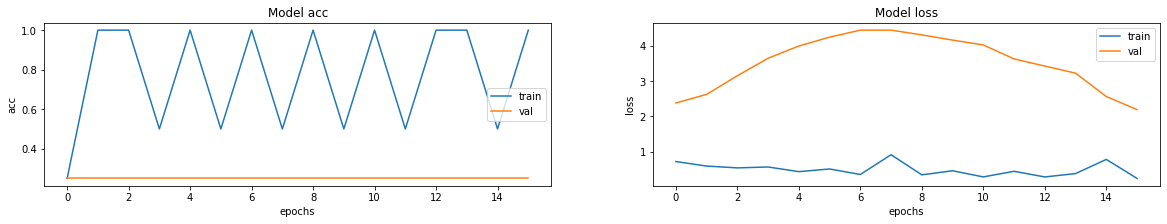

In [19]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [20]:
# Load best weights.
model.load_weights("3d_image_classification.h5")
prediction = model.predict(np.expand_dims(x_val[0], axis=0))[0]
scores = [1 - prediction[0], prediction[0]]

class_names = ["normal", "abnormal"]
for score, name in zip(scores, class_names):
    print(
        "This model is %.2f percent confident that CT scan is %s"
        % ((100 * score), name)
    )

1/1 [==============================] - 2s 2s/step
This model is 91.08 percent confident that CT scan is normal
This model is 8.92 percent confident that CT scan is abnormal
